In [58]:
# Import libraries
import torch
import torch.nn as nn
import torch.amp as amp
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd

# We use pickle to load the CIFAR-10 dataset
import pickle

# We use os and urllib to download and extract the dataset
import os
import urllib.request

# We use tarfile to extract the downloaded tar.gz file
import tarfile

import time


In [59]:
# Load CIFAR-10 dataset manually with PyTorch
def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as f: # Open the file
        data = pickle.load(f, encoding='bytes') # Load the batch

    # Reshape images    
    images = data[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # Reshape and transpose to (N, H, W, C)
    images = torch.tensor(images, dtype=torch.float32)  # Convert to PyTorch tensor with float32
    labels = torch.tensor(data[b'labels'], dtype=torch.long) # Get labels as PyTorch tensor
    return images, labels

# Data augmentation functions
def random_crop(img, crop_size=32, padding=4):
    # Pad the image
    img = F.pad(img.permute(2, 0, 1), (padding, padding, padding, padding), mode='constant', value=0).permute(1, 2, 0)
    h, w = img.shape[:2]

    # Random crop
    top = torch.randint(0, h - crop_size + 1, (1,)).item()
    left = torch.randint(0, w - crop_size + 1, (1,)).item()
    
    return img[top:top + crop_size, left:left + crop_size]

def random_horizontal_flip(img):
    if torch.rand(1) > 0.5:
        return torch.flip(img, dims=[1])
    return img

def random_erasing(img, p=0.5, sl=0.02, sh=0.4, r1=0.3):
    if torch.rand(1) > p:
        return img
    img_h, img_w = img.shape[:2]
    s = torch.rand(1).uniform_(sl, sh) * img_h * img_w
    r = torch.rand(1).uniform_(r1, 1/r1)
    w = int(torch.sqrt(s / r))
    h = int(torch.sqrt(s * r))
    left = torch.randint(0, img_w - w + 1, (1,)).item() if w < img_w else 0
    top = torch.randint(0, img_h - h + 1, (1,)).item() if h < img_h else 0
    img[top:top+h, left:left+w] = 0
    return img

def random_gaussian_noise(img, std=0.05):
    noise = torch.randn_like(img) * std
    return img + noise

def augment_image(img):
    img = random_crop(img)
    img = random_horizontal_flip(img)
    img = random_erasing(img)
    img = random_gaussian_noise(img)
    return img

# Define data directory
data_dir = './data/cifar-10-batches-py' 

# Download if not present
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    urllib.request.urlretrieve(url, './data/cifar-10.tar.gz')

    # Extract the tar file
    with tarfile.open('./data/cifar-10.tar.gz', 'r:gz') as tar:
        tar.extractall('./data')

# Load training data (5 batches of 10,000 images each)
train_images = []
train_labels = []
for i in range(1, 6):
    images, labels = load_cifar10_batch(f'{data_dir}/data_batch_{i}')
    train_images.append(images)
    train_labels.append(labels)

# We need to concatenate all training images because they are in separate batches
train_images = torch.cat(train_images) 
train_labels = torch.cat(train_labels)  

# Load test data
test_images, test_labels = load_cifar10_batch(f'{data_dir}/test_batch')

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Normalize images (mean/std for CIFAR-10)
mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2023, 0.1994, 0.2010])
train_images = (train_images / 255.0 - mean) / std
test_images = (test_images / 255.0 - mean) / std

# Convert to PyTorch tensors (N, C, H, W)
train_images = train_images.permute(0, 3, 1, 2)
test_images = test_images.permute(0, 3, 1, 2)

train_images = train_images.to(device)
test_images = test_images.to(device)
train_labels = train_labels.to(device)
test_labels = test_labels.to(device)

print(f'Train: {len(train_images)}, Test: {len(test_images)}')

C:\Users\Manousos Kirkinis\AppData\Local\Temp\ipykernel_8504\750106364.py:4: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  data = pickle.load(f, encoding='bytes') # Load the batch


Using device: cuda
Train: 50000, Test: 10000


In [60]:
# Define CNN using PyTorch nn.Module

class CustomCNN(nn.Module):
    def __init__(self, filters1=32, filters2=64, filters3=128, filters4=256, dropout_rate=0.5):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, filters1, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(filters1)
        self.conv2 = nn.Conv2d(filters1, filters2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters2)
        self.conv3 = nn.Conv2d(filters2, filters3, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(filters3)
        self.conv4 = nn.Conv2d(filters3, filters4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(filters4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(filters4 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = x.reshape(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [61]:
# Define loss function (Cross-Entropy)
def cross_entropy_loss(y_pred, y_true):
    batch_size = y_pred.shape[0]

    # Clip predictions to avoid log(0) error
    y_pred = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
    log_probs = -torch.log(y_pred[torch.arange(batch_size, device=y_pred.device), y_true])
    return torch.mean(log_probs)

# Softmax function
def softmax(x):
    exp_x = torch.exp(x - torch.max(x, dim=1, keepdims=True)[0])
    return exp_x / torch.sum(exp_x, dim=1, keepdims=True)

# Gradient of loss
def d_cross_entropy_loss(y_pred, y_true):
    batch_size = y_pred.shape[0]
    grad = y_pred.clone()

    # Subtract 1 from the predicted probabilities of the true classes 
    # to compute the gradient of the cross-entropy loss with respect to the predictions (softmax output).
    grad[torch.arange(batch_size, device=y_pred.device), y_true] -= 1
    return grad / batch_size

In [62]:
# Hyperparameter Search with Grid Search and Stratified Cross-Validation

from sklearn.model_selection import StratifiedKFold

# Define hyperparameter lists
lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01] # learning rates
bs_list = [32, 64, 128] #batch sizes
dr_list = [0.2, 0.3, 0.4, 0.5] # dropout rates
wd_list = [0, 1e-5, 1e-4, 1e-3] # weight decay

best_val_acc = 0
best_params = {}

total_combos = len(lr_list) * len(bs_list) * len(dr_list) * len(wd_list)
print(f"Total combinations: {total_combos}")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

combo_count = 0
for lr in lr_list:
    for bs in bs_list:
        for dr in dr_list:
            for wd in wd_list:
                combo_count += 1
                print(f"Testing combo {combo_count}/{total_combos}: lr={lr}, bs={bs}, dr={dr}, wd={wd}")
                
                fold_accs = []
                for fold, (train_idx, val_idx) in enumerate(skf.split(train_images, train_labels.cpu().numpy())):
                    # Split data for this fold
                    fold_train_images = train_images[train_idx]
                    fold_train_labels = train_labels[train_idx]
                    fold_val_images = train_images[val_idx]
                    fold_val_labels = train_labels[val_idx]
                    
                    torch.manual_seed(42)
                    model = CustomCNN(dropout_rate=dr).to(device)
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                    scaler = torch.amp.GradScaler()
                    
                    # Train for 5 epochs (increased for deeper model)
                    for epoch in range(5):
                        model.train()
                        indices = torch.randperm(len(fold_train_images))
                        fold_train_images_shuf = fold_train_images[indices]
                        fold_train_labels_shuf = fold_train_labels[indices]
                        
                        running_loss = 0.0
                        correct = 0
                        total = 0
                        
                        for i in range(0, len(fold_train_images_shuf), bs):
                            batch_x = fold_train_images_shuf[i:i+bs]
                            batch_y = fold_train_labels_shuf[i:i+bs]
                            
                            # Apply data augmentation
                            batch_x_aug = torch.zeros_like(batch_x)
                            for j in range(len(batch_x)):
                                img = batch_x[j].permute(1, 2, 0)
                                img_aug = augment_image(img)
                                batch_x_aug[j] = img_aug.permute(2, 0, 1)
                            batch_x = batch_x_aug
                            
                            with amp.autocast('cuda'):
                                out = model(batch_x)
                                loss = F.cross_entropy(out, batch_y, label_smoothing=0.1)
                            
                            # Backward 
                            scaler.scale(loss).backward()
                            scaler.step(optimizer)
                            scaler.update()
                            optimizer.zero_grad()
                            
                            running_loss += loss.item() * len(batch_x)
                            preds = torch.argmax(out, dim=1)
                            correct += torch.sum(preds == batch_y).item()
                            total += len(batch_x)
                    
                    # Validation
                    model.eval()
                    val_correct = 0
                    val_total = 0
                    with torch.no_grad():
                        for j in range(0, len(fold_val_images), 64):
                            val_batch_x = fold_val_images[j:j+64]
                            val_batch_y = fold_val_labels[j:j+64]
                            val_out = model(val_batch_x)
                            val_preds = torch.argmax(val_out, dim=1)
                            val_correct += torch.sum(val_preds == val_batch_y).item()
                            val_total += len(val_batch_x)
                    
                    fold_acc = 100 * val_correct / val_total
                    fold_accs.append(fold_acc)
                
                avg_val_acc = sum(fold_accs) / len(fold_accs)
                print(f"Average Val Acc: {avg_val_acc:.2f}%")
                
                if avg_val_acc > best_val_acc:
                    best_val_acc = avg_val_acc
                    best_params = {'lr': lr, 'bs': bs, 'dr': dr, 'wd': wd}

print(f"Best combo: {best_params}, Avg Val Acc: {best_val_acc:.2f}%")

# Set the best hyperparameters
lr = best_params['lr']
bs = best_params['bs']
dr = best_params['dr']
wd = best_params['wd']

Total trials: 50
Trial 1/50: lr=0.005, bs=32, dr=0.4, wd=0.0001
Average Val Acc: 64.59%
Trial 2/50: lr=0.001, bs=64, dr=0.4, wd=0.0001
Average Val Acc: 74.06%
Trial 3/50: lr=0.0005, bs=128, dr=0.5, wd=0.0001
Average Val Acc: 71.31%
Trial 4/50: lr=0.0005, bs=128, dr=0.4, wd=0
Average Val Acc: 72.38%
Trial 5/50: lr=0.001, bs=32, dr=0.5, wd=0.0001
Average Val Acc: 73.00%
Trial 6/50: lr=0.0001, bs=256, dr=0.5, wd=0.01
Average Val Acc: 64.07%
Trial 7/50: lr=0.0001, bs=128, dr=0.6, wd=0.001
Average Val Acc: 65.93%
Trial 8/50: lr=0.005, bs=256, dr=0.3, wd=1e-05
Average Val Acc: 66.00%
Trial 9/50: lr=0.0005, bs=128, dr=0.3, wd=0.001
Average Val Acc: 71.61%
Trial 10/50: lr=0.001, bs=32, dr=0.5, wd=0.0001
Average Val Acc: 73.00%
Trial 11/50: lr=0.01, bs=128, dr=0.3, wd=0.0001
Average Val Acc: 55.97%
Trial 12/50: lr=0.01, bs=64, dr=0.6, wd=0
Average Val Acc: 42.77%
Trial 13/50: lr=0.0005, bs=32, dr=0.3, wd=0.0001
Average Val Acc: 74.23%
Trial 14/50: lr=0.0005, bs=32, dr=0.2, wd=1e-05
Average Val 

In [63]:
# Training loop with PyTorch

from sklearn.model_selection import StratifiedKFold

torch.manual_seed(42)  # For reproducibility

# Using best hyperparameters from search
print(f"Using hyperparameters: lr={lr}, bs={bs}, dr={dr}, wd={wd}")

model = CustomCNN(dropout_rate=dr).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
scaler = torch.amp.GradScaler()

num_epochs = 30
patience = 5  # Early stopping
best_val_acc = 0
patience_counter = 0

train_losses, val_losses, train_accs, val_accs = [], [], [], []

# Use StratifiedKFold for train/val split
skf_train = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
train_idx, val_idx = next(skf_train.split(train_images, train_labels.cpu().numpy()))

val_images = train_images[val_idx]
val_labels = train_labels[val_idx]
train_images_eff = train_images[train_idx]
train_labels_eff = train_labels[train_idx]

# Training and validation loop
for epoch in range(num_epochs):
    epoch_start = time.time()
    model.train()

    # Shuffle train data
    indices = torch.randperm(len(train_images_eff))
    train_images_shuf = train_images_eff[indices]
    train_labels_shuf = train_labels_eff[indices]
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    for i in range(0, len(train_images_shuf), bs):
        batch_x = train_images_shuf[i:i+bs]
        batch_y = train_labels_shuf[i:i+bs]
        
        # Apply data augmentation to training batch
        batch_x_aug = torch.zeros_like(batch_x)
        for j in range(len(batch_x)):
            img = batch_x[j].permute(1, 2, 0)  # (H, W, C)
            img_aug = augment_image(img)
            batch_x_aug[j] = img_aug.permute(2, 0, 1)  # (C, H, W)
        batch_x = batch_x_aug
        
        # Forward with mixed precision
        with amp.autocast('cuda'):
            out = model(batch_x)
            loss = F.cross_entropy(out, batch_y, label_smoothing=0.1)
        
        # Backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        
        running_loss += loss.item() * len(batch_x)
        preds = torch.argmax(out, dim=1)
        correct += torch.sum(preds == batch_y).item()
        total += len(batch_x)
    
    train_loss = running_loss / len(train_images_eff)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for j in range(0, len(val_images), 64):
            val_batch_x = val_images[j:j+64]
            val_batch_y = val_labels[j:j+64]
            val_out = model(val_batch_x)
            val_loss = F.cross_entropy(val_out, val_batch_y)
            val_preds = torch.argmax(val_out, dim=1)
            val_running_loss += val_loss.item() * len(val_batch_x)
            val_correct += torch.sum(val_preds == val_batch_y).item()
            val_total += len(val_batch_x)
    
    val_loss = val_running_loss / len(val_images)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    scheduler.step()
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break
    
    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

# Load best model
model.load_state_dict(torch.load('best_model.pth'))

Using hyperparameters: lr=0.001, bs=32, dr=0.2, wd=0
Epoch 1/30, Train Loss: 1.6760, Train Acc: 45.40%, Val Loss: 1.1331, Val Acc: 60.34%, Time: 8.31s
Epoch 2/30, Train Loss: 1.4276, Train Acc: 58.48%, Val Loss: 0.9780, Val Acc: 66.10%, Time: 8.29s
Epoch 3/30, Train Loss: 1.3227, Train Acc: 63.92%, Val Loss: 0.9309, Val Acc: 68.62%, Time: 8.28s
Epoch 4/30, Train Loss: 1.2530, Train Acc: 67.35%, Val Loss: 0.7674, Val Acc: 74.66%, Time: 8.28s
Epoch 5/30, Train Loss: 1.2098, Train Acc: 69.42%, Val Loss: 0.8346, Val Acc: 72.92%, Time: 8.27s
Epoch 6/30, Train Loss: 1.1663, Train Acc: 71.44%, Val Loss: 0.7121, Val Acc: 76.88%, Time: 8.31s
Epoch 7/30, Train Loss: 1.1422, Train Acc: 72.67%, Val Loss: 0.7063, Val Acc: 76.62%, Time: 8.30s
Epoch 8/30, Train Loss: 1.1158, Train Acc: 74.11%, Val Loss: 0.6832, Val Acc: 77.82%, Time: 8.34s
Epoch 9/30, Train Loss: 1.0964, Train Acc: 74.88%, Val Loss: 0.6500, Val Acc: 79.16%, Time: 8.42s
Epoch 10/30, Train Loss: 1.0807, Train Acc: 75.66%, Val Loss: 0.6

<All keys matched successfully>

Test Accuracy: 85.77%


C:\Users\Manousos Kirkinis\AppData\Local\Temp\ipykernel_8504\750106364.py:4: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  data = pickle.load(f, encoding='bytes') # Load the batch


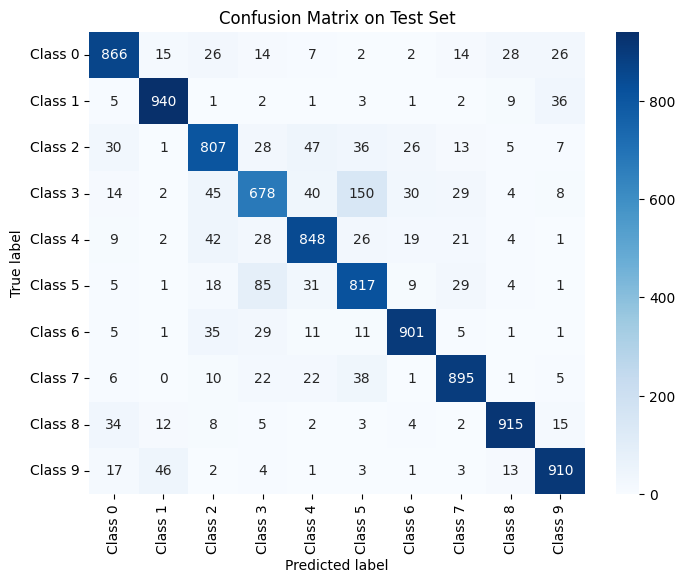

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1000
           1       0.92      0.94      0.93      1000
           2       0.81      0.81      0.81      1000
           3       0.76      0.68      0.72      1000
           4       0.84      0.85      0.84      1000
           5       0.75      0.82      0.78      1000
           6       0.91      0.90      0.90      1000
           7       0.88      0.90      0.89      1000
           8       0.93      0.92      0.92      1000
           9       0.90      0.91      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



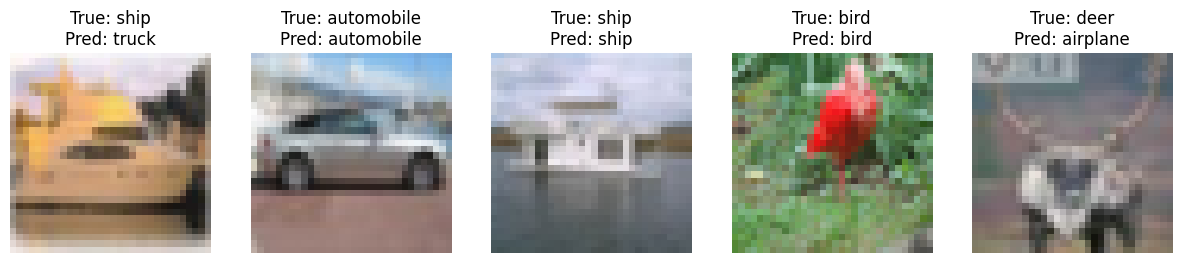

In [64]:
# Evaluate the CNN on the test dataset (unknown data)

# Load test data
test_images, test_labels = load_cifar10_batch(f'{data_dir}/test_batch')

# Normalize test images
test_images = (test_images / 255.0 - mean) / std
test_images = test_images.permute(0, 3, 1, 2)  # (N, C, H, W)
test_images = test_images.to(device)
test_labels = test_labels.to(device)

model.eval()  # Disable dropout for inference

# Evaluate on test set
with torch.no_grad():
    test_out = model(test_images)
    test_preds = torch.argmax(test_out, dim=1)

test_acc = 100 * torch.sum(test_preds == test_labels).item() / len(test_labels)
print(f"Test Accuracy: {test_acc:.2f}%")

# Confusion Matrix
cm = confusion_matrix(test_labels.cpu().numpy(), test_preds.cpu().numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[f'Class {i}' for i in range(10)], yticklabels=[f'Class {i}' for i in range(10)])
plt.title('Confusion Matrix on Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(test_labels.cpu().numpy(), test_preds.cpu().numpy()))

# Show some example predictions
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Denormalize for display
test_images_display = test_images.cpu().permute(0, 2, 3, 1) * std + mean
test_images_display = torch.clamp(test_images_display, 0, 1)

# Select 5 random examples
torch.manual_seed(42)
indices = torch.randperm(len(test_images))[:5]

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, idx in enumerate(indices):
    img = test_images_display[idx].cpu().numpy()
    true_label = class_names[test_labels[idx].item()]
    pred_label = class_names[test_preds[idx].item()]
    axes[i].imshow(img)
    axes[i].set_title(f'True: {true_label}\nPred: {pred_label}')
    axes[i].axis('off')
plt.show()

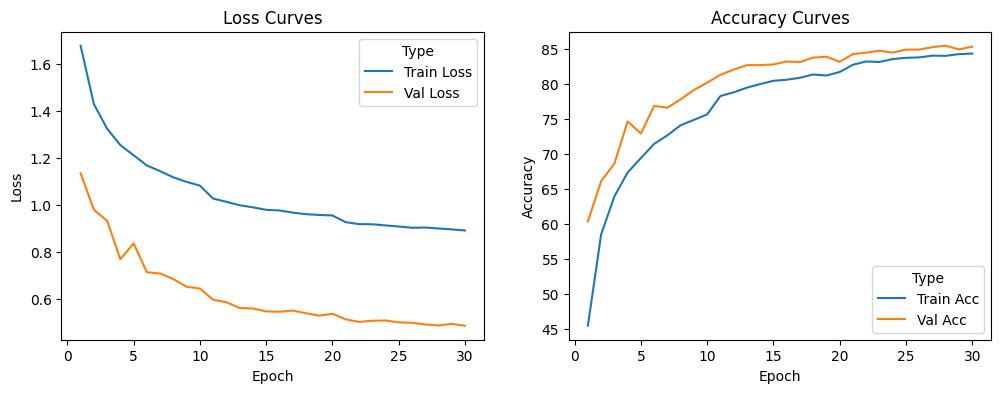

In [65]:
# Model Evaluation
# Plot training vs validation curves using Seaborn
df = pd.DataFrame({
    'Epoch': range(1, len(train_losses) + 1),
    'Train Loss': [float(x) for x in train_losses],
    'Val Loss': [float(x) for x in val_losses],
    'Train Acc': [float(x) for x in train_accs],
    'Val Acc': [float(x) for x in val_accs]
})

df_melted_loss = df.melt(id_vars='Epoch', value_vars=['Train Loss', 'Val Loss'], var_name='Type', value_name='Loss')
df_melted_acc = df.melt(id_vars='Epoch', value_vars=['Train Acc', 'Val Acc'], var_name='Type', value_name='Accuracy')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.lineplot(data=df_melted_loss, x='Epoch', y='Loss', hue='Type')
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
sns.lineplot(data=df_melted_acc, x='Epoch', y='Accuracy', hue='Type')
plt.title('Accuracy Curves')
plt.show()